In [22]:
from datasets import load_dataset
import pandas as pd


RANDOM_STATE = 42


df = load_dataset("scikit-learn/auto-mpg")["train"].to_pandas()
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [3]:
print("Размер:", df.shape)
print("\nИнформация:")
print(df.info())
print("\nПропуски:")
print(df.isna().sum())

Размер: (398, 9)

Информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB
None

Пропуски:
mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64


In [23]:
import numpy as np

df["horsepower"] = (
    df["horsepower"]
    .replace("?", np.nan)
    .astype(float)
)

# Убираем car name (шум)
df = df.drop(columns="car name")


In [24]:
from sklearn.model_selection import train_test_split

X = df.drop(columns="mpg")
y = df["mpg"]

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=RANDOM_STATE
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE
)


In [25]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

num_features = [
    "cylinders",
    "displacement",
    "horsepower",
    "weight",
    "acceleration",
    "model year"
]

cat_features = ["origin"]

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])


In [34]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# mean baseline
y_pred_mean = np.full_like(y_val, y_train.mean())


# median baseline
y_pred_median = np.full_like(y_val, y_train.median())


metrics = []
for name, preds in [("Mean", y_pred_mean), ("Median", y_pred_median)]:
    metrics.append({
        "Model": name,
        "MAE": mean_absolute_error(y_val, preds),
        "RMSE": np.sqrt(mean_squared_error(y_val, preds)),
        "R2": r2_score(y_val, preds)
    })


pd.DataFrame(metrics)

,Model,MAE,RMSE,R2
0,Mean,5.890053,7.080125,-0.001576
1,Median,5.890000,7.134283,-0.016957


Бейзлайны демонстрируют большой масштаб ошибок и отрицательные значения R², что ожидаемо для константных моделей и задаёт нижнюю границу качества.

In [35]:
from sklearn.linear_model import LinearRegression

linreg = Pipeline([
    ("prep", preprocess),
    ("model", LinearRegression())
])

linreg.fit(X_train, y_train)

linreg.fit(X_train, y_train)


linreg.fit(X_train, y_train)
y_val_pred = linreg.predict(X_val)


mae = mean_absolute_error(y_val, y_val_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
r2 = r2_score(y_val, y_val_pred)


mae, rmse, r2

(2.2955266556777567, np.float64(2.9226549680340583), 0.8293300340095469)

MAE
Средняя абсолютная ошибка снизилась более чем в 2.5 раза, в среднем модель ошибается всего на ~2–3 mpg, что является хорошим результатом для данной задачи.

RMSE
Уменьшился почти в 2.5 раза, модель существенно лучше справляется с объектами, где возможны большие ошибки

R²
R^2 стал положительным(бейзлайны не объясняли дисперсию данных), модель объясняет около 83% вариаций целевой переменной, это очень резкий качественный скачок

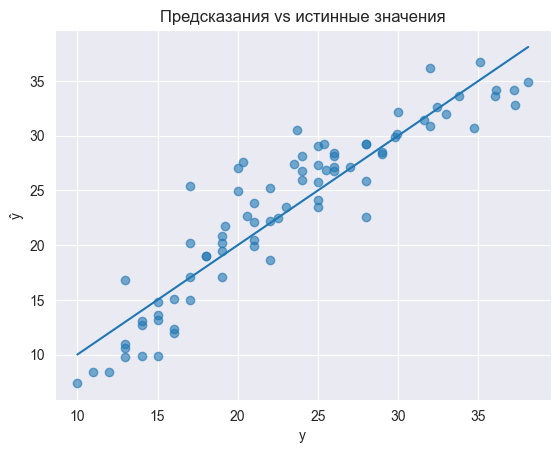

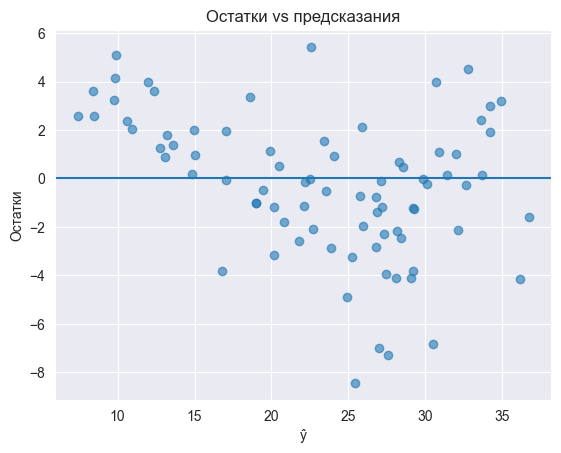

In [29]:
import matplotlib.pyplot as plt


plt.figure()
plt.scatter(y_val, y_val_pred, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()])
plt.xlabel("y")
plt.ylabel("ŷ")
plt.title("Предсказания vs истинные значения")
plt.show()


residuals = y_val - y_val_pred
plt.figure()
plt.scatter(y_val_pred, residuals, alpha=0.6)
plt.axhline(0)
plt.xlabel("ŷ")
plt.ylabel("Остатки")
plt.title("Остатки vs предсказания")
plt.show()

Диаграмма соответствия предсказанных и истинных значений демонстрирует выраженную линейную зависимость и близость точек к линии y = x, модель улавливает основной тренд, но разброс увеличивается на краях диапазона.
Основная масса ошибок умеренная, систематического смещения почти нет

График остатков показывает, что ошибки распределены вокруг нулевого значения без выраженного систематического паттерна. Остатки в среднем центрированы вокруг нуля, при больших значениях ŷ наблюдается больший разброс остатков, при низких остатки завышаются но с небольшой дисперсией.
Присутствует умеренная гетероскедастичность, что указывает на ограниченность линейной модели при описании крайних значений. Дисперсия ошибок растёт с увеличением mpg. Выбросы объясняются физическими особенностями автомобилей(редкие конфигурации)

In [30]:
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline

sgd_mse = Pipeline([
    ("prep", preprocess),
    ("model", SGDRegressor(
        loss="squared_error",
        random_state=RANDOM_STATE,
        max_iter=5000,
        tol=1e-3
    ))
])

sgd_mse.fit(X_train, y_train)
y_val_pred_mse = sgd_mse.predict(X_val)

In [31]:
sgd_mae = Pipeline([
    ("prep", preprocess),
    ("model", SGDRegressor(
        loss="epsilon_insensitive",
        epsilon=0.0,
        random_state=RANDOM_STATE,
        max_iter=5000,
        tol=1e-3
    ))
])

sgd_mae.fit(X_train, y_train)
y_val_pred_mae = sgd_mae.predict(X_val)

In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd

results = pd.DataFrame([
    {
        "Model": "SGD (MSE)",
        "MAE": mean_absolute_error(y_val, y_val_pred_mse),
        "RMSE": np.sqrt(mean_squared_error(y_val, y_val_pred_mse)),
        "R2": r2_score(y_val, y_val_pred_mse)
    },
    {
        "Model": "SGD (MAE)",
        "MAE": mean_absolute_error(y_val, y_val_pred_mae),
        "RMSE": np.sqrt(mean_squared_error(y_val, y_val_pred_mae)),
        "R2": r2_score(y_val, y_val_pred_mae)
    }
])

results

,Model,MAE,RMSE,R2
0,SGD (MSE),2.403469,3.061366,0.812745
1,SGD (MAE),2.302099,2.935478,0.827829


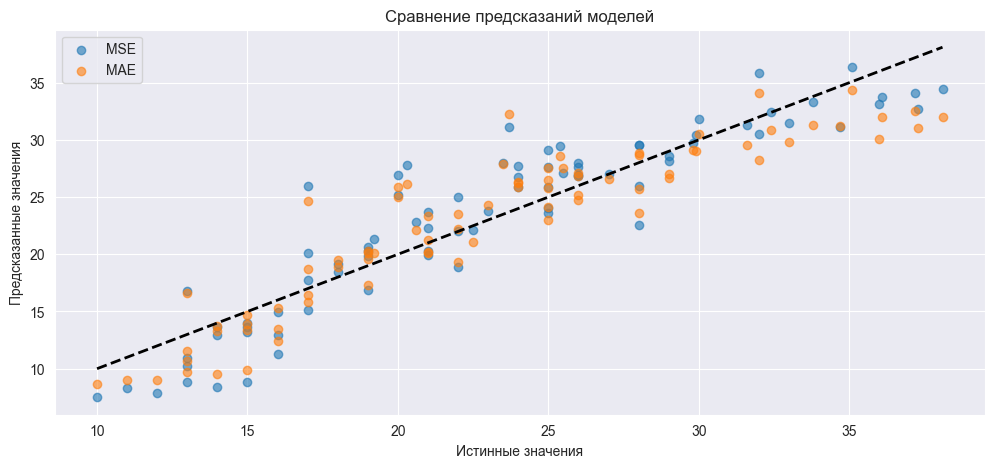

In [38]:
plt.figure(figsize=(12,5))

plt.scatter(y_val, y_val_pred_mse, alpha=0.6, label='MSE')
plt.scatter(y_val, y_val_pred_mae, alpha=0.6, label='MAE')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
plt.xlabel("Истинные значения")
plt.ylabel("Предсказанные значения")
plt.title("Сравнение предсказаний моделей")
plt.legend()
plt.show()


Модели показывают себя практически одинаково, но MAE обеспечивает более устойчивые и равномерные предсказания, снижая влияние редких выбросов, по графику видно, что на крайних значениях разброс модели с MAE чуть выше. Выбор функции потерь влияет на компромисс между точностью предсказаний для типичных объектов и устойчивостью модели к редким аномалиям

In [40]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd

y_test_pred = sgd_mae.predict(X_test)

mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))

rmsle_test = rmsle(y_test, y_test_pred)

mae_val = mean_absolute_error(y_val, y_val_pred_mae)
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred_mae))
r2_val = r2_score(y_val, y_val_pred_mae)
rmsle_val = rmsle(y_val, y_val_pred_mae)

results_test = pd.DataFrame([
    {
        "Dataset": "Validation",
        "MAE": mae_val,
        "RMSE": rmse_val,
        "R2": r2_val,
        "RMSLE": rmsle_val
    },
    {
        "Dataset": "Test",
        "MAE": mae_test,
        "RMSE": rmse_test,
        "R2": r2_test,
        "RMSLE": rmsle_test
    }
])

print(results_test)


      Dataset       MAE      RMSE        R2     RMSLE
0  Validation  2.302099  2.935478  0.827829  0.134349
1        Test  2.659499  3.540952  0.802543  0.146803


Стабильность высокая, хотя небольшое увеличение ошибок на тесте указывает на наличие более сложных точек, которые модель предсказывает хуже. Модель, выбранная по MAE, показывает хорошие показатели по метрикам, обобщающая способность высокая.
Разброс между валидацией и тестом умеренный, нет признаков сильного переобучения.

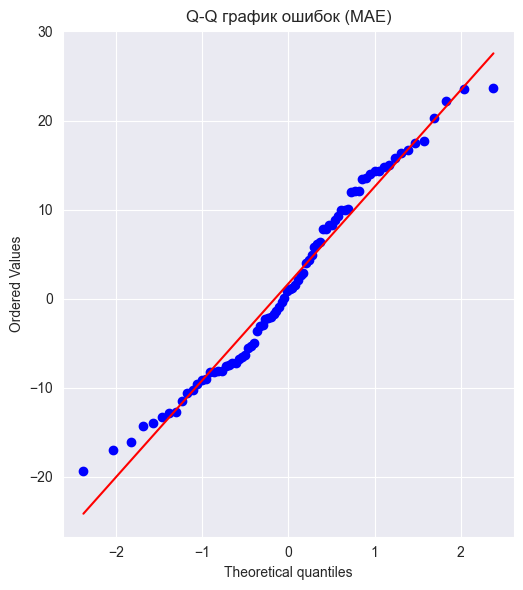

In [41]:
# Q-Q
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

errors_mae = y_test - y_val_pred_mae

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 2)
stats.probplot(errors_mae, dist="norm", plot=plt)
plt.title("Q-Q график ошибок (MAE)")

plt.tight_layout()
plt.show()


Основная масса ошибок модели лежит на прямой линии графика, что указывает на почти нормальное распределение ошибок. Незначительные отклонения точек на концах графика свидетельствуют о редких выбросах или экстремальных значениях(что типично для линейных моделей), которые немного отличаются от основной тенденции, но не оказывают существенного влияния на работу модели для большинства данных.